In [8]:
import numpy as np
import pandas as pd
# %matplotlib widget
# import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
X_train = np.load('./data/X_train.npy')
X_test = np.load('./data/X_test.npy')

y_train = pd.read_csv('./data/y_train.csv')
# y_test = pd.read_csv('./data/y_test.csv')
# y_test = pd.read_csv('./data/sample_submission.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Обработка данных по частям
batch_size = 50
n_observations, n_sensors, n_time_points = X_train.shape

# Обучение модели
model = RandomForestClassifier(n_estimators=100)

for i in range(0, n_observations, batch_size):
    X_batch = X_train[i:i+batch_size, :, :]
    y_batch = y_train.iloc[i*100:(i+batch_size)*100, 0]
    X_batch = X_batch.reshape(X_batch.shape[0] * n_time_points, n_sensors)
    model.fit(X_batch, y_batch)

# Предсказание на тестовой выборке
n_observations, n_sensors, n_time_points = X_test.shape
y_pred = np.zeros((n_observations * n_time_points,))

for i in range(0, n_observations, batch_size):
    X_batch = X_test[i:i+batch_size, :, :]
    X_batch = X_batch.reshape(X_batch.shape[0] * n_time_points, n_sensors)
    y_pred[i*100:(i+batch_size)*100] = model.predict(X_batch)

MemoryError: could not allocate 327680000 bytes

In [ ]:
import pandas as pd

# Создание датафрейма с предиктами
n_observations, n_sensors, n_time_points = X_test.shape
sample_timesteps = []
classes = []
for i in range(n_observations):
    for j in range(n_time_points):
        sample_timesteps.append(f"{i}-{j}")
        classes.append(y_pred[i*n_time_points + j])

submission_df = pd.DataFrame({
    "sample-timestep": sample_timesteps,
    "class": classes
})

# Сохранение датафрейма в файл
submission_df.to_csv("data/submission.csv", index=False)

# Подготовка данных

Проверка на выбросы

In [3]:
dupl_columns = list(y_train.columns)

mask = y_train.duplicated(subset=dupl_columns)
hotels_with_dupls = y_train[mask]
print(f'Число найденных дубликатов: {hotels_with_dupls.shape[0]}')

Число найденных дубликатов: 0


In [4]:
def make_array(y_data):
    
    y_data[['sample_id', 'timestep']] = y_data['sample-timestep'].str.split('-', n=1, expand=True).astype(int)
    y_data = y_data.pivot(index='sample_id', columns='timestep', values='class')
    # y_data_index = y_data.index
    y_data = y_data.sort_index() # на всякий случай
    y_data = y_data.values

    return y_data


print(y_train.shape)

(32300, 2)


In [5]:
# Преобразование X_train
# X_train_reshaped = X_train.reshape(323, 40 * 100)  # Reshape to 2D

# Преобразование y_train
# y_train_reshaped = y_train.reshape(323, 100)

In [6]:
# print(X_train_reshaped.min(), X_train_reshaped.mean(), X_train_reshaped.max(), X_train_reshaped.std())

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

# Преобразование данных
X_train_reshaped = X_train.reshape(323, 40 * 100)
X_test_reshaped = X_test.reshape(-1, 40 * 100)
y_train_reshaped = make_array(y_train).reshape(323, 100)
# y_test_reshaped = make_array(y_test).reshape(54, 100)

In [8]:
# Нормализация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

In [9]:
# Отбор признаков
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), max_features=50)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_reshaped[:, 0])
X_test_selected = selector.transform(X_test_scaled)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV

# Определение базовой модели
base_model = RandomForestClassifier(n_jobs=-1, random_state=42)

# Определение параметров для оптимизации
param_dist = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [10, 20, 30, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

# Создание MultiOutputClassifier
multi_output_model = MultiOutputClassifier(estimator=base_model, n_classes=8)

# Выполнение случайного поиска
random_search = RandomizedSearchCV(multi_output_model, param_distributions=param_dist, 
                                   n_iter=10, cv=2, verbose=2, random_state=42, n_jobs=-1)

# Обучение модели
random_search.fit(X_train_selected, y_train_reshaped)

# Получение лучшей модели
best_model = random_search.best_estimator_

# Предсказание
y_pred = best_model.predict(X_test_selected)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

## Тут уклон в жест 0, его гораздо больше остальных

In [101]:
# Расчет F1-score
# f1_micro = f1_score(y_test_reshaped.ravel(), y_pred.ravel(), average='micro')
# f1_macro = f1_score(y_test_reshaped.ravel(), y_pred.ravel(), average='macro')
# f1_weighted = f1_score(y_test_reshaped.ravel(), y_pred.ravel(), average='weighted')

# print(f"Micro-averaged F1-score: {f1_micro}")
# print(f"Macro-averaged F1-score: {f1_macro}")
# print(f"Weighted F1-score: {f1_weighted}")

# Расчет F1-score для каждого класса
# f1_per_class = f1_score(y_test_reshaped.ravel(), y_pred.ravel(), average=None)
# for i, score in enumerate(f1_per_class):
#     print(f"F1-score for class {i}: {score}")

Micro-averaged F1-score: 0.10425925925925926
Macro-averaged F1-score: 0.08186194958118344
Weighted F1-score: 0.08157864364144424
F1-score for class 0: 0.16882758620689656
F1-score for class 1: 0.0744466800804829
F1-score for class 2: 0.0903225806451613
F1-score for class 3: 0.05343511450381679
F1-score for class 4: 0.0801644398766701
F1-score for class 5: 0.06896551724137931
F1-score for class 6: 0.05904059040590406
F1-score for class 7: 0.06830309498399147
F1-score for class 8: 0.0732519422863485


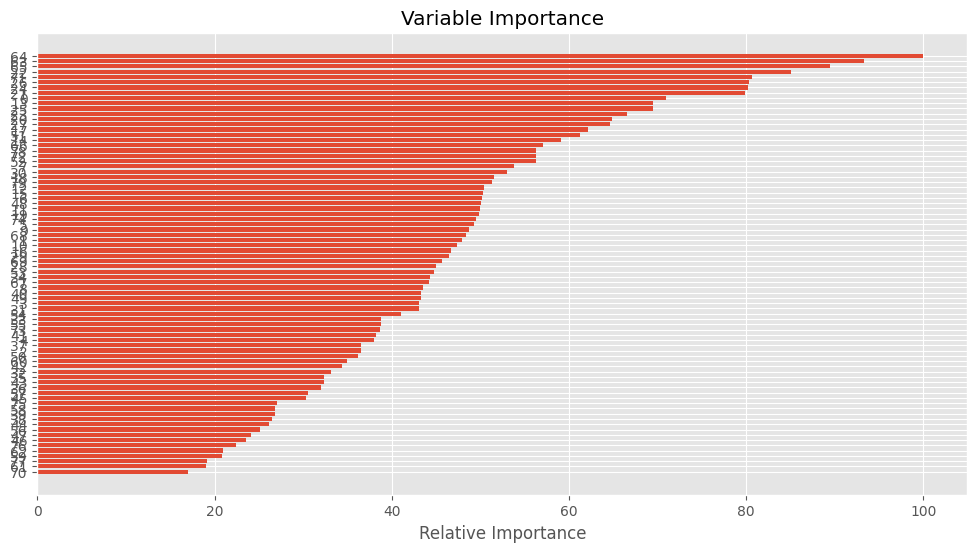

In [102]:
# Визуализация важности признаков
import matplotlib.pyplot as plt

feature_importance = best_model.estimators_[0].feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, sorted_idx)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
# Дополнительные улучшения: ансамблевый метод
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

gb_model = MultiOutputClassifier(GradientBoostingClassifier(random_state=42))
svm_model = MultiOutputClassifier(SVC(probability=True, random_state=42))

gb_model.fit(X_train_selected, y_train_reshaped)
svm_model.fit(X_train_selected, y_train_reshaped)

y_pred_rf = best_model.predict_proba(X_test_selected)
y_pred_gb = gb_model.predict_proba(X_test_selected)
y_pred_svm = svm_model.predict_proba(X_test_selected)

In [143]:
y_pred_gb[:,:,-6]

array([[2.48115127e-08, 7.19469934e-09, 2.91202155e-07, ...,
        3.32495097e-09, 5.47976683e-08, 3.34891978e-09],
       [2.48115127e-08, 7.19469934e-09, 2.91202155e-07, ...,
        3.32495097e-09, 5.47976683e-08, 3.34891978e-09],
       [2.48115127e-08, 7.19469934e-09, 2.91202155e-07, ...,
        3.32495097e-09, 5.47976683e-08, 3.34891978e-09],
       ...,
       [3.76872176e-06, 2.45612401e-03, 2.77386216e-04, ...,
        7.52515523e-05, 2.15696407e-05, 7.30774197e-04],
       [3.76872176e-06, 2.45612401e-03, 2.77386216e-04, ...,
        7.52515523e-05, 2.15696407e-05, 7.30774197e-04],
       [3.76872176e-06, 2.45612401e-03, 2.77386216e-04, ...,
        7.52515523e-05, 2.15696407e-05, 7.30774197e-04]])

In [133]:
from sklearn.metrics import f1_score

# Убедимся, что все предсказания имеют одинаковый формат
y_pred_rf = np.array(y_pred_rf)
y_pred_gb = np.array(y_pred_gb)
y_pred_svm = np.array(y_pred_svm)

# Приведем все предсказания к одинаковой размерности, если это необходимо
# Например, если SVM возвращает только метки классов, а не вероятности:
if len(y_pred_svm.shape) == 1:
    n_classes = len(np.unique(y_train_reshaped))
    y_pred_svm = np.eye(n_classes)[y_pred_svm]

# Теперь можно усреднить вероятности
y_pred_ensemble = (y_pred_rf + y_pred_gb + y_pred_svm) / 3

# Получаем предсказанные классы
y_pred_ensemble_class = np.argmax(y_pred_ensemble, axis=1)

y_train_reshaped = y_train_reshaped.reshape(-1, 100, 2)
y_pred_ensemble_class = y_pred_ensemble_class.reshape(-1, 100, 2)  # Убедимся, что предсказания тоже одномерные

# Убедимся, что размерности совпадают
# assert len(y_train_reshaped) == len(y_pred_ensemble_class), "Размерности y_test и y_pred не совпадают"

# Расчет F1-score для ансамбля
f1_ensemble = f1_score(y_train_reshaped, y_pred_ensemble_class, average='micro')
print(f"Ensemble Micro-averaged F1-score: {f1_ensemble}")

ValueError: cannot reshape array of size 32300 into shape (100,2)

In [134]:
y_train_reshaped.shape

(32300,)

In [135]:
y_pred_ensemble_class.shape

(100, 9)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn.linear_model import LogisticRegression

estimators = [
    ('lr', linear_model.LogisticRegression(
        max_iter = 1000, 
        random_state=42, 
        solver='sag')),
    ('dt',  tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42, #генератор случайных чисел
    )),
    ('rf', ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf=5, #list
    random_state=42 #генератор случайных чисел
    ))
]

# Создаем объект класса стекинг
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42, solver='sag')
)
# Обучаем модель
clf.fit(X_train_scaled, y_train)

In [ ]:
# Сохранение лучшей модели
import joblib
joblib.dump(best_model, 'best_model.joblib')

# Если нужно сделать предсказания на реальных тестовых данных
X_real_test = np.load('data/X_test.npy')
X_real_test_reshaped = X_real_test.reshape(X_real_test.shape[0], -1)
X_real_test_scaled = scaler.transform(X_real_test_reshaped)
X_real_test_selected = selector.transform(X_real_test_scaled)

y_real_pred = best_model.predict(X_real_test_selected)

# Сохранение предсказаний в формате для отправки
submission = pd.DataFrame({
    'sample-timestep': [f"{i}-{j}" for i in range(y_real_pred.shape[0]) for j in range(y_real_pred.shape[1])],
    'class': y_real_pred.ravel()
})
submission.to_csv('submission.csv', index=False)

print("Prediction completed and saved to submission.csv")

Вывод: 
Надо Select_best features и переобучить модель на них, чтобы повысить метрику